In [226]:
!pip install xgboost

     -------------------------------------- 125.4/125.4 MB 9.0 MB/s eta 0:00:00


In [234]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

Vamos a definir una funcion (Mergeador_data) que tome el dataset de las observaciones y el dataset de DAM_GEODATA, haga un merge y se quede con los features de los que luego analizaremos la varianza

In [159]:
#Traemos los data frames

PVR_observaciones_18 = pd.read_csv('PVR_observaciones_promedio_cutoff18.csv')
PVR_observaciones = pd.read_csv('PVR_Obs_Cutoff.csv', delimiter= ';')
PVR_DAM_geodata = pd.read_csv('../Data/PVR_DAM_geodata.csv', delimiter= ';')

def Mergeador_data (data1, data2):
    
    #Guardamos las variables en forma global, para llamarlas en cualquier momento
    global PVR_train_test, DAM_to_predict, PVR_train_test_copy
    
    #La funcion elimina los puntos del tipo intersección, Además guarda las intersecciones para luego hacer predicciones
    DAM_to_predict = data1[data1['punto_tipo'] == 'Intersercción']
    PVR_geodata = data1.drop(data1[data1['punto_tipo'] == 'Intersercción'].index)
    
    PVR_train_test = pd.merge(data2, data1 , how="left", on=["ID"]) 
    
    #Una vez que tenemos el PVR_train_test final, vamos a eliminar sus nulls
    PVR_train_test.dropna(axis=0, inplace= True)
    
    #Dejamos los features de ID, index, x, y, punto_tipo solo para las predicciones
    PVR_train_test_copy = PVR_train_test.copy()
    PVR_train_test.drop(['ID', 'index','x','y', 'punto_tipo'], axis=1, inplace= True)  
    
    #Hacemos dummies
    PVR_train_test = pd.get_dummies(PVR_train_test, drop_first=True)

In [161]:
#Invocamos al mergeador
Mergeador_data(PVR_DAM_geodata, PVR_observaciones_18)

In [162]:
PVR_train_test

,clasificacion,poblacion,hogares,desocupado,0-14,65_mas,inicial,primario,egb,secundario,...,post_universitario,lee_y _esc,NoLee_ni_e,hacinamiento,sin_agua,sin_cloaca,densidad_comercial,microzonificacion_Comercial,microzonificacion_Residencial urbano,macrozonificacion_Urbano
0,1,778.0,239.0,31.0,170.0,82.0,26.0,163.0,55.0,257.0,...,2.0,705.0,37.0,4.0,0.0,2.0,16.0,0,1,1
1,1,1018.0,346.0,46.0,182.0,195.0,40.0,216.0,27.0,274.0,...,14.0,922.0,58.0,2.0,0.0,2.0,12.0,0,1,1
2,0,878.0,309.0,27.0,123.0,192.0,20.0,115.0,38.0,181.0,...,36.0,831.0,25.0,0.0,0.0,2.0,5.0,0,1,1
4,0,452.0,169.0,24.0,49.0,92.0,8.0,55.0,19.0,102.0,...,12.0,439.0,8.0,0.0,0.0,0.0,17.0,0,1,1
5,1,411.0,192.0,11.0,50.0,100.0,13.0,41.0,11.0,90.0,...,17.0,390.0,10.0,2.0,0.0,0.0,80.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,315.0,165.0,7.0,20.0,65.0,0.0,29.0,3.0,75.0,...,12.0,310.0,2.0,0.0,3.0,0.0,42.0,0,0,0
76,0,309.0,142.0,7.0,23.0,48.0,4.0,21.0,4.0,58.0,...,11.0,297.0,4.0,0.0,3.0,0.0,34.0,1,0,0
77,0,1020.0,358.0,41.0,192.0,91.0,30.0,96.0,72.0,213.0,...,16.0,941.0,33.0,0.0,0.0,1.0,47.0,1,0,0
78,1,528.0,188.0,11.0,87.0,102.0,16.0,40.0,24.0,82.0,...,23.0,487.0,16.0,0.0,0.0,0.0,8.0,0,1,1


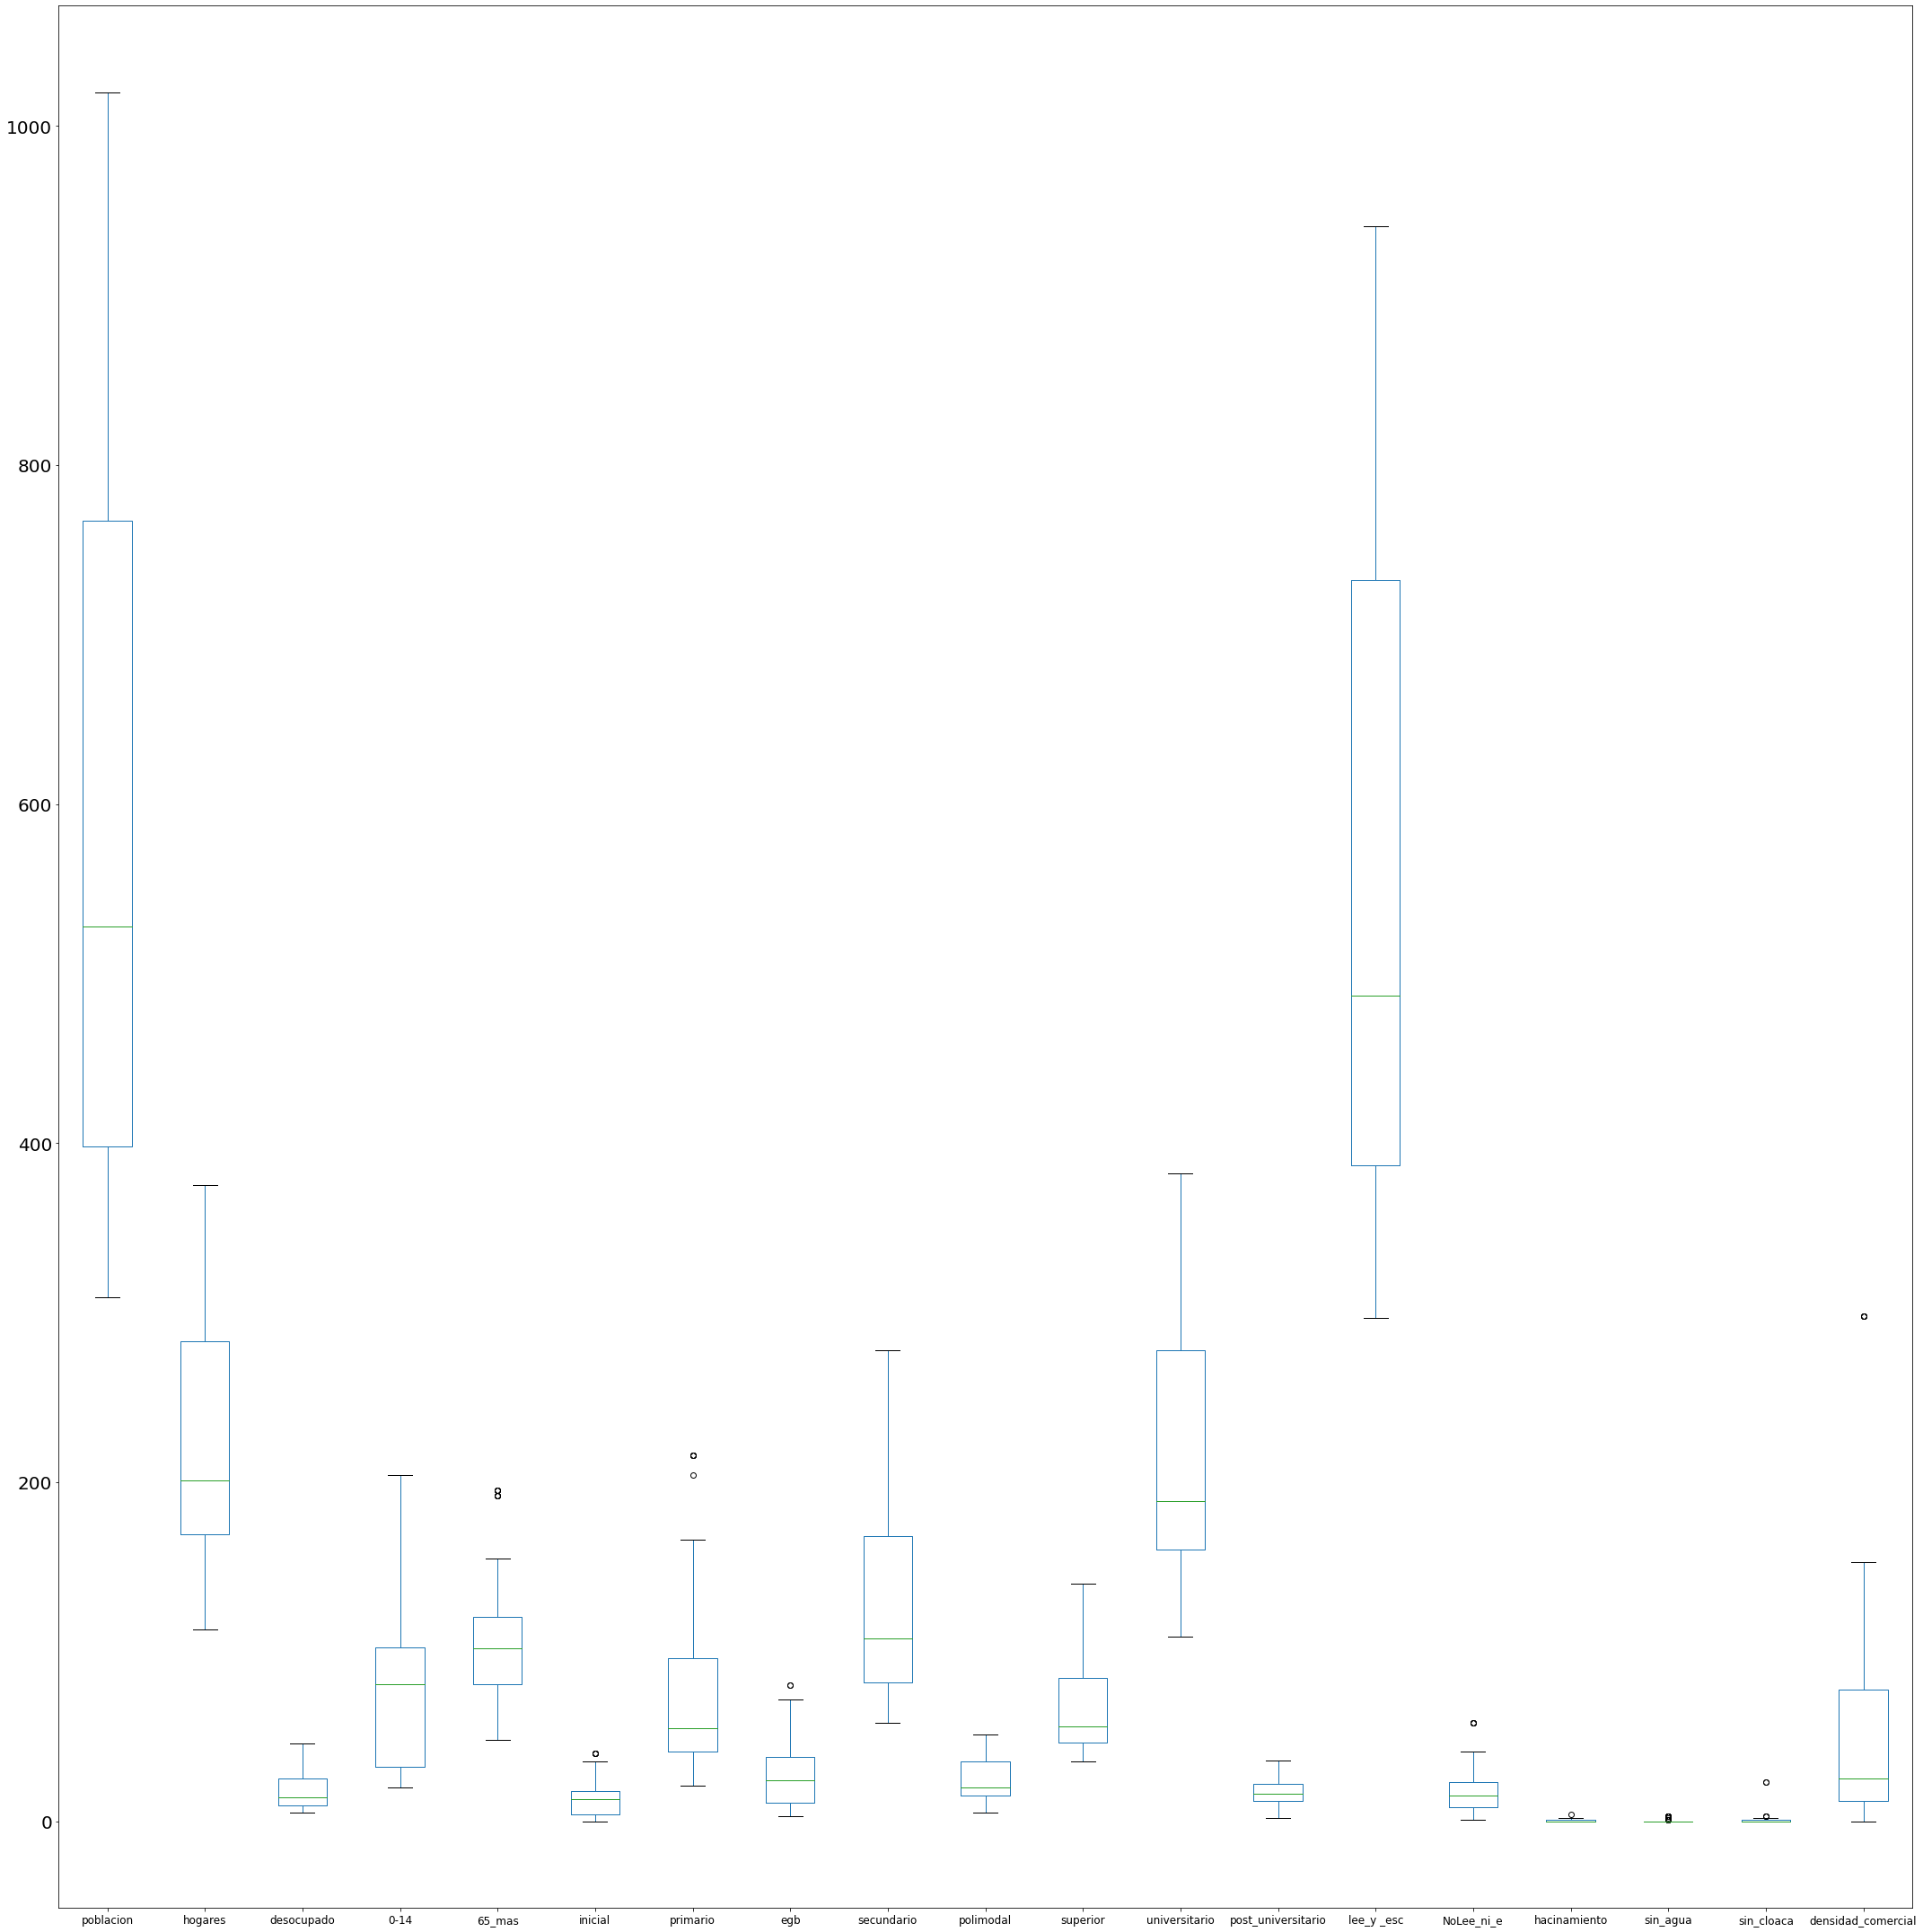

In [163]:
#Visualizacion de outliers

plt.rcParams["figure.figsize"] = [30, 30]
plt.rcParams["figure.autolayout"] = True

ax = PVR_train_test[['poblacion','hogares', 'desocupado', '0-14', '65_mas', 'inicial', 'primario', 'egb', 'secundario', 'polimodal', 'superior', 'universitario', 'post_universitario', 'lee_y _esc', 'NoLee_ni_e',
       'hacinamiento', 'sin_agua', 'sin_cloaca', 'densidad_comercial', ]].plot(kind='box')
plt.xticks(fontsize=12)
plt.yticks(fontsize=20)

plt.show()

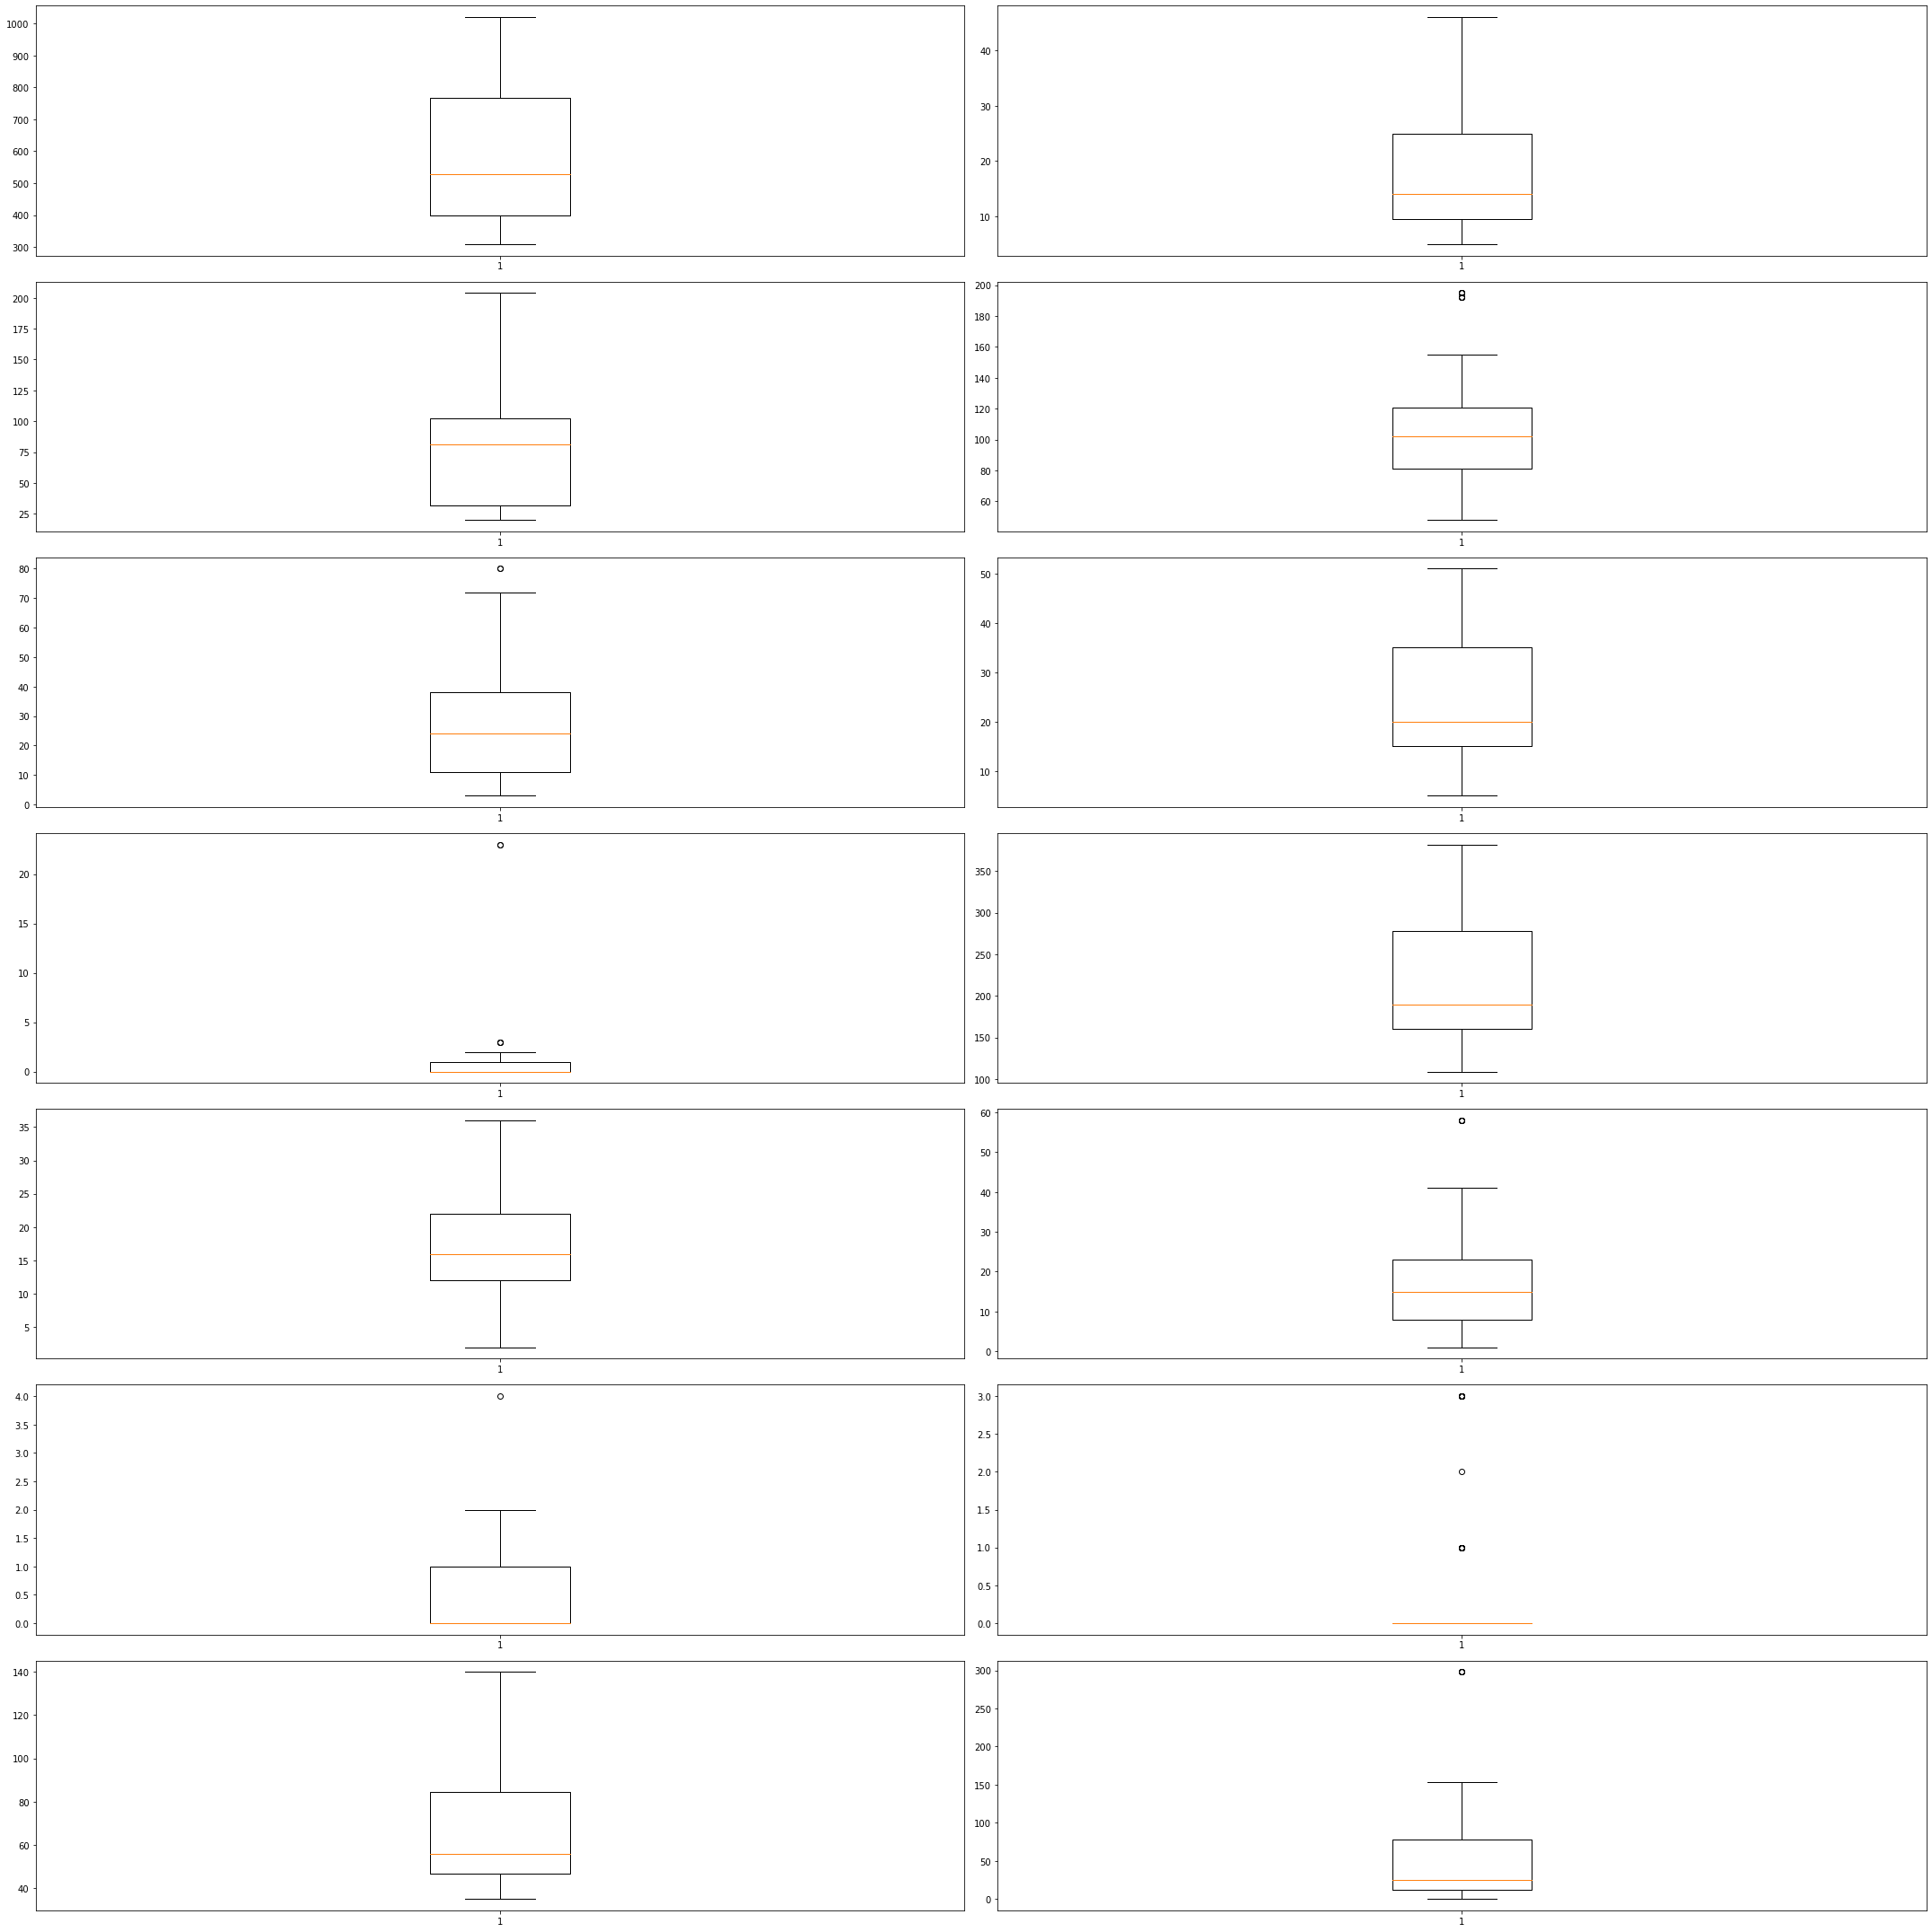

In [165]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) , (ax9, ax10) , (ax11, ax12) , (ax13, ax14)) = plt.subplots(7, 2)

ax1.boxplot(PVR_train_test['poblacion'])
ax2.boxplot(PVR_train_test['desocupado'])

ax3.boxplot(PVR_train_test['0-14'])
ax4.boxplot(PVR_train_test['65_mas'])

ax5.boxplot(PVR_train_test['egb'])
ax6.boxplot(PVR_train_test['polimodal'])

ax7.boxplot(PVR_train_test['sin_cloaca'])
ax8.boxplot(PVR_train_test['universitario'])

ax9.boxplot(PVR_train_test['post_universitario'])
ax10.boxplot(PVR_train_test['NoLee_ni_e'])

ax11.boxplot(PVR_train_test['hacinamiento'])
ax12.boxplot(PVR_train_test['sin_agua'])

ax13.boxplot(PVR_train_test['superior'])
ax14.boxplot(PVR_train_test['densidad_comercial'])

plt.show()

In [169]:
outlier= []

def detect_outliers_iqr(data):
    
    data = sorted(data)
    q1= np.percentile(data,25)
    q3= np.percentile(data,75)
        
    IQR= q3-q1
    
    lwr_bound= q1 - (1.5*IQR)
    upr_bound = q3 + (1.5*IQR)
        
    
    for j in data:
        if (j<lwr_bound or j>upr_bound):
            outlier.append(j)
    
    return outlier

In [170]:
detect_outliers_iqr(PVR_train_test['egb'])

[80.0, 80.0]

Ahora invocamos la función y creado el dataset hagamos otra que se quede con los mejores features, splitee los datos y nos guarde el dataset para entrenar.

In [291]:
def Preparando_data (data1):
    
    global x_train, x_test, y_train, y_test
    
    #Aca colocamos la seleccion de los mejores features 
    
    #Separamos el X y el target
    
    X = PVR_train_test[PVR_train_test.columns.difference(['clasificacion'])]
    #X = PVR_train_test[['0-14', 'densidad_comercial', 'universitario', 'post_universitario', '65_mas']]
    y = PVR_train_test['clasificacion']
    
    #Splieteamos
    x_train, x_test, y_train, y_test = train_test_split(X,y, stratify= y, test_size= 0.3, random_state= 9)
    
    #Estandarizamos los datos (lo dejamos muteado)
    #x_train_std, x_test_std = MinMaxScaler(x_train, x_test)
    
    print('La distribucion de etiquetas es: ', y_train.value_counts() / y_train.value_counts().sum())
    
       

In [292]:
#Generamos los datos para darle de comer al modelo
Preparando_data(PVR_train_test)

La distribucion de etiquetas es:  0    0.509091
1    0.490909
Name: clasificacion, dtype: float64


# Bagging

In [275]:
    classifier = {
        'KNeighbors': KNeighborsClassifier(),
        'LinearSCV': LinearSVC(),
        'SVC': SVC(),
        'SGDC': SGDClassifier(),
        'DecisionTree': DecisionTreeClassifier()
    }
    
    for name, estimator in classifier.items():
        bag_class = BaggingClassifier(base_estimator=estimator, n_estimators=5).fit(x_train, y_train)
        bag_pred = bag_class.predict(x_test)

        print('Accuracy Bagging with {}:'.format(name), accuracy_score(bag_pred, y_test))
        print('')

Accuracy Bagging with KNeighbors: 0.5833333333333334

Accuracy Bagging with LinearSCV: 0.5

Accuracy Bagging with SVC: 0.5

Accuracy Bagging with SGDC: 0.4583333333333333

Accuracy Bagging with DecisionTree: 0.5



C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DataScience\anaconda3\envs\dhdsblend2021\li

# Boosting

In [293]:
    cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
    
    params = {  
    "n_estimators": [50,100,500],      
    "max_depth": [1,2,3,4],            
    "learning_rate": [0.05,0.075,0.1,0.25,0.5,0.75,1],      
    }
    
    params2 = {  
    "n_estimators": [50,100,500],      
                
    "learning_rate": [0.05,0.075,0.1,0.25,0.5,0.75,1],      
    }
    
    #XG Boost
    
    model_xg = XGBClassifier(n_jobs=-1, use_label_encoder=False)
    
    xgb = GridSearchCV(model_xg, param_grid=params, cv=cv, verbose=1, n_jobs=-1)

    xgb.fit(x_train,y_train)
    
    #Gradient Boosting
    
    model_gb = GradientBoostingClassifier()
    
    gb = GridSearchCV(model_gb, param_grid=params, cv=cv, verbose=1, n_jobs=-1)
    
    gb.fit(x_train,y_train)
    
    #Ada Boost 
    
        
    model_abc = AdaBoostClassifier()
    
    abc = GridSearchCV(model_abc, param_grid=params2, cv=cv, verbose=1, n_jobs=-1)
    
    abc.fit(x_train, y_train)   

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 405 out of 420 | elapsed:    5.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   10.8s finished


Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  90 out of 105 | elapsed:    7.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    8.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5, 0.75,
                                           1],
                         'n_estimators': [50, 100, 500]},
             verbose=1)

In [294]:
def evaluar_rendimiento(modelo, nombre, X, y, cv):
    s = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))

In [295]:
evaluar_rendimiento(xgb.best_estimator_,"XG Boost", x_train, y_train, cv)

Rendimiento de XG Boost:	0.527 ± 0.068


In [296]:
evaluar_rendimiento(gb.best_estimator_,"Gradient Boosting", x_train, y_train, cv)

Rendimiento de Gradient Boosting:	0.473 ± 0.106


In [297]:
evaluar_rendimiento(abc.best_estimator_,"Ada Boost", x_train, y_train, cv)

Rendimiento de Ada Boost:	0.527 ± 0.068


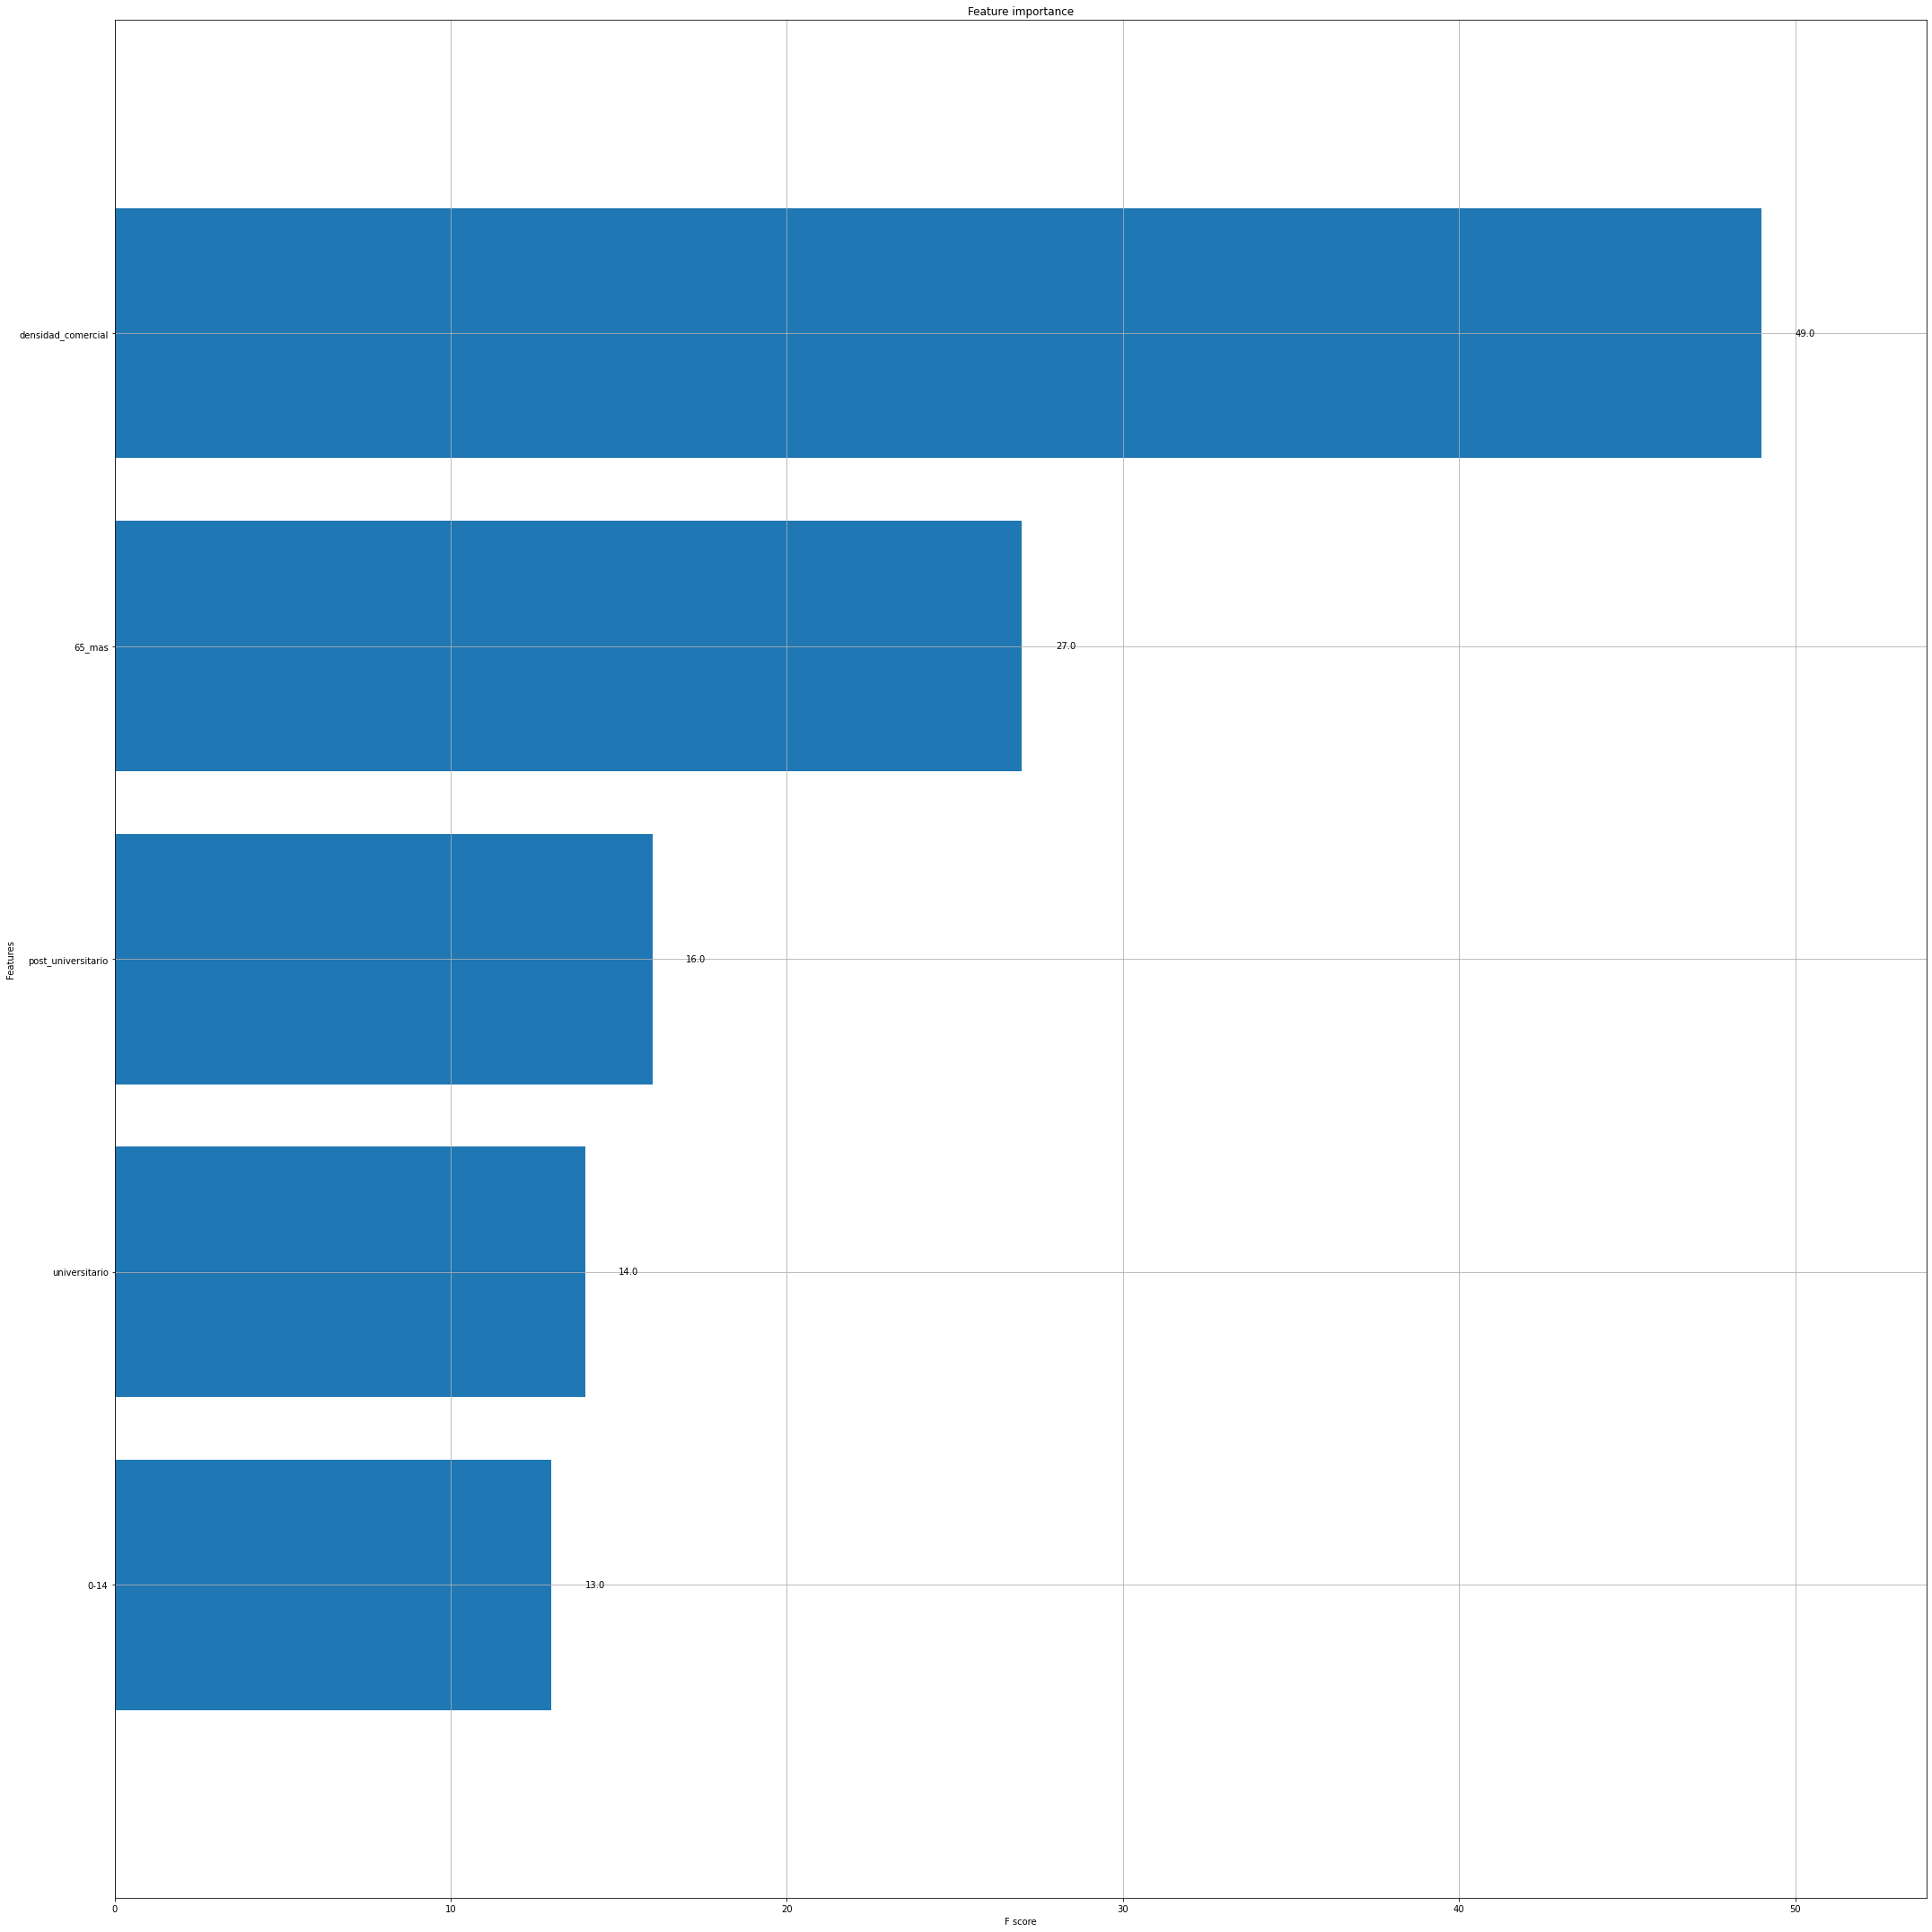

In [298]:
from xgboost import plot_importance
plot_importance(xgb.best_estimator_, height = 0.8,max_num_features=5);